In [1]:
!pip install transformers
!pip install tensorflow

In [2]:
from transformers import logging, BertTokenizerFast

import random
import os

import tensorflow as tf
from tensorflow import keras
from keras import layers

import matplotlib.pyplot as plt
import re
import string

import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder

2022-06-20 08:43:57.080461: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-20 08:43:57.080548: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# setting up seed
seed = 123

os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

logging.set_verbosity_error()

In [4]:
BATCH_SIZE = 32 # batch size used on the train and validation set
NUM_TRAIN_EPOCHS = 5 # number of iterations for the model training
MAX_SEQ_LENGTH = 128 # used to cut/pad the text into tokens

In [5]:
# Loading the dataset
path = '../../datasets/'
taxonomy = pd.read_csv(path + 'taxonomy.csv')
queries, labels = taxonomy['query'].to_numpy(), taxonomy['label'].to_numpy()

In [6]:
# Encoding the labels to binary values
bin_encoder=LabelEncoder()
taxonomy.label = bin_encoder.fit_transform(taxonomy.label)

queries, labels = taxonomy['query'].to_numpy(), taxonomy['label'].to_numpy()

In [7]:
val_split = 250 # 10% of the full dataset
test_split = 500 # 20% of the full dataset
train_split = 50 

# Separating the negative and positive samples for manual stratification
x_positives, y_positives = queries[labels == 1], labels[labels == 1]
x_negatives, y_negatives = queries[labels == 0], labels[labels == 0]

# Creating training, validation and testing splits
x_val, y_val = (
    np.concatenate([x_positives[:val_split], x_negatives[:val_split]]), 
    np.concatenate([y_positives[:val_split], y_negatives[:val_split]])
)

x_test, y_test = (
    np.concatenate([x_positives[val_split : val_split + test_split],
                    x_negatives[val_split : val_split + test_split]]), 
    np.concatenate([y_positives[val_split : val_split + test_split],
                    y_negatives[val_split : val_split + test_split]])
)

x_train, y_train = (
        np.concatenate([x_positives[val_split + test_split : val_split + test_split + train_split],
                        x_negatives[val_split + test_split : val_split + test_split + train_split]]), 
        np.concatenate([y_positives[val_split + test_split : val_split + test_split + train_split],
            y_negatives[val_split + test_split : val_split + test_split + train_split]])
)

# Remaining pool of samples are stored separately. These are only labeled as and when required
x_pool_samples, y_pool_samples = (
        np.concatenate([x_positives[val_split + test_split + train_split :], 
                       x_negatives[val_split + test_split + train_split :]]),
        np.concatenate([y_positives[val_split + test_split + train_split :],
                       y_negatives[val_split + test_split + train_split :]])
)

df_train = pd.DataFrame({'query': x_train, 'label': y_train}, columns = ['query', 'label'])
df_test = pd.DataFrame({'query': x_test, 'label': y_test}, columns = ['query', 'label'])
df_val = pd.DataFrame({'query': x_val, 'label': y_val}, columns = ['query', 'label'])

df_pool_samples = pd.DataFrame({'query': x_pool_samples, 'label': y_pool_samples}, columns = ['query', 'label'])

In [8]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

def tokenize(sentence):
    tokens = tokenizer.encode_plus(sentence, max_length=MAX_SEQ_LENGTH,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_attention_mask=True,
                                   return_token_type_ids=False, return_tensors='tf')
    return tokens['input_ids'], tokens['attention_mask']

# initialize two arrays for input tensors
Xids_train = np.zeros((len(df_train), MAX_SEQ_LENGTH))
Xmask_train = np.zeros((len(df_train), MAX_SEQ_LENGTH))

for i, sentence in enumerate(df_train['query']):
    Xids_train[i, :], Xmask_train[i, :] = tokenize(sentence)

# initialize two arrays for input tensors
Xids_test = np.zeros((len(df_test), MAX_SEQ_LENGTH))
Xmask_test = np.zeros((len(df_test), MAX_SEQ_LENGTH))

for i, sentence in enumerate(df_test['query']):
    Xids_test[i, :], Xmask_test[i, :] = tokenize(sentence)

# initialize two arrays for input tensors
Xids_val = np.zeros((len(df_val), MAX_SEQ_LENGTH))
Xmask_val = np.zeros((len(df_val), MAX_SEQ_LENGTH))

for i, sentence in enumerate(df_val['query']):
    Xids_val[i, :], Xmask_val[i, :] = tokenize(sentence)

# initialize two arrays for input tensors
Xids_pool_samples = np.zeros((len(df_pool_samples), MAX_SEQ_LENGTH))
Xmask_pool_samples = np.zeros((len(df_pool_samples), MAX_SEQ_LENGTH))

for i, sentence in enumerate(df_pool_samples['query']):
    Xids_pool_samples[i, :], Xmask_pool_samples[i, :] = tokenize(sentence)

2022-06-20 08:44:01.369647: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-20 08:44:01.370768: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-20 08:44:01.370887: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-06-20 08:44:01.370996: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-06-20 08:44:01.371103: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [9]:
arr_train = df_train['label'].values  # take query column in df as array
labels_train = np.zeros((arr_train.size, arr_train.max()+1))  # initialize empty (all zero) label array
labels_train[np.arange(arr_train.size), arr_train] = 1  # add ones in indices where we have a value

arr_test = df_test['label'].values  # take query column in df as array
labels_test = np.zeros((arr_test.size, arr_test.max()+1))  # initialize empty (all zero) label array
labels_test[np.arange(arr_test.size), arr_test] = 1  # add ones in indices where we have a value

arr_val = df_val['label'].values  # take query column in df as array
labels_val = np.zeros((arr_val.size, arr_val.max()+1))  # initialize empty (all zero) label array
labels_val[np.arange(arr_val.size), arr_val] = 1  # add ones in indices where we have a value

arr_pool_samples = df_pool_samples['label'].values  # take query column in df as array
labels_pool_samples = np.zeros((arr_pool_samples.size, arr_pool_samples.max()+1))  # initialize empty (all zero) label array
labels_pool_samples[np.arange(arr_pool_samples.size), arr_pool_samples] = 1  # add ones in indices where we have a value

In [10]:
# Creating TF Datasets for faster prefetching and parallelization
train_dataset = tf.data.Dataset.from_tensor_slices((Xids_train, Xmask_train, labels_train))
test_dataset = tf.data.Dataset.from_tensor_slices((Xids_test, Xmask_test, labels_test))
val_dataset = tf.data.Dataset.from_tensor_slices((Xids_val, Xmask_val, labels_val))

pool_samples = tf.data.Dataset.from_tensor_slices((Xids_pool_samples, Xmask_pool_samples, labels_pool_samples))

# create a mapping function that we use to restructure our dataset
def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

# using map method to apply map_func to dataset
train_dataset = train_dataset.map(map_func, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
pool_samples = pool_samples.map(map_func, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

test_dataset = test_dataset.batch(BATCH_SIZE).map(map_func, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).map(map_func, num_parallel_calls=tf.data.AUTOTUNE)

In [11]:
# Helper function for merging new history objects with older ones
def append_history(losses, val_losses, accuracy, val_accuracy, history):
    losses = losses + history.history["loss"]
    val_losses = val_losses + history.history["val_loss"]
    accuracy = accuracy + history.history["binary_accuracy"]
    val_accuracy = val_accuracy + history.history["val_binary_accuracy"]
    return losses, val_losses, accuracy, val_accuracy


# Plotter function
def plot_history(losses, val_losses, accuracies, val_accuracies):
    plt.plot(losses)
    plt.plot(val_losses)
    plt.legend(["train_loss", "val_loss"])
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    plt.plot(accuracies)
    plt.plot(val_accuracies)
    plt.legend(["train_accuracy", "val_accuracy"])
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()

In [12]:
from transformers import TFBertModel

def create_model():
    # initialize cased BERT model
    bert = TFBertModel.from_pretrained('bert-base-uncased')

    input_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), name='input_ids', dtype='int32')
    mask = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), name='attention_mask', dtype='int32')

    # we consume the last_hidden_state tensor from bert (discarding pooled_outputs)
    embeddings = bert(input_ids, attention_mask=mask)[0]

    X = tf.keras.layers.LSTM(64)(embeddings)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Dense(64, activation='relu')(X)
    X = tf.keras.layers.Dropout(0.1)(X)
    y = tf.keras.layers.Dense(2, activation='sigmoid', name='outputs')(X)

    # define input and output layers of our model
    model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

    # freeze the BERT layer - otherwise we will be training 100M+ parameters...
    model.layers[2].trainable = False

    model.summary()
    return model

In [13]:
def train_active_learning_models(
    train_dataset,
    pool_samples,
    val_dataset,
    test_dataset,
    num_iterations=4,
    sampling_size=100,
):

    # Creating lists for storing metrics
    losses, val_losses, accuracies, val_accuracies = [], [], [], []

    model = create_model()
    # We will monitor the false positives and false negatives predicted by our model
    # These will decide the subsequent sampling ratio for every Active Learning loop
    model.compile(
        loss="binary_crossentropy",
        optimizer="rmsprop",
        metrics=[
            tf.keras.metrics.BinaryAccuracy(),
            tf.keras.metrics.FalseNegatives(),
            tf.keras.metrics.FalsePositives()
        ],
    )

    # Defining checkpoints.
    # The checkpoint callback is reused throughout the training since it only saves the best overall model.
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        "BERT_AL_Random.h5", save_best_only=True, verbose=1
    )
    # Here, patience is set to 4. This can be set higher if desired.
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=4, verbose=1)

    print(f"Starting to train with {len(train_dataset)} samples")
    # Initial fit with a small subset of the training set
    history = model.fit(
        train_dataset.cache().shuffle(500).batch(BATCH_SIZE),
        epochs=NUM_TRAIN_EPOCHS,
        validation_data=val_dataset,
        callbacks=[checkpoint, early_stopping],
    )

    # Appending history
    losses, val_losses, accuracies, val_accuracies = append_history(
        losses, val_losses, accuracies, val_accuracies, history
    )

    for iteration in range(num_iterations):
        # Getting predictions from previously trained model
        predictions = model.predict(test_dataset)

        # Evaluating the number of zeros and ones incorrectly classified
        _, _, false_negatives, false_positives = model.evaluate(test_dataset, verbose=0)

        print("-" * 100)
        print(
            f"Number of zeros incorrectly classified: {false_negatives}, Number of ones incorrectly classified: {false_positives}"
        )

        # Sample the required number of ones and zeros
        sampled_dataset = pool_samples.take(sampling_size)

        # Skip the sampled data points to avoid repetition of sample
        pool_samples = pool_samples.skip(sampling_size)
        
        print('Pool samples:', pool_samples)

        # Concatenating the train_dataset with the sampled_dataset
        train_dataset = train_dataset.concatenate(sampled_dataset).prefetch(tf.data.AUTOTUNE)

        print(f"Starting training with {len(train_dataset)} samples")
        print("-" * 100)

        # We recompile the model to reset the optimizer states and retrain the model
        model.compile(
            loss="categorical_crossentropy",
            optimizer="rmsprop",
            metrics=[
                tf.keras.metrics.BinaryAccuracy(),
                tf.keras.metrics.FalseNegatives(),
                tf.keras.metrics.FalsePositives()
            ],
        )

        history = model.fit(
            train_dataset.cache().shuffle(500).batch(BATCH_SIZE),
            validation_data=val_dataset,
            epochs=NUM_TRAIN_EPOCHS,
            callbacks=[
                checkpoint,
                early_stopping,
            ],
        )

        # Appending the history
        losses, val_losses, accuracies, val_accuracies = append_history(
            losses, val_losses, accuracies, val_accuracies, history
        )

        # Loading the best model from this training loop
        model = tf.keras.models.load_model("BERT_AL_Random.h5", custom_objects={"TFBertModel": TFBertModel})

    # Plotting the overall history and evaluating the final model
    plot_history(losses, val_losses, accuracies, val_accuracies)
    print("-" * 100)
    print(
        "Test set evaluation: ",
        model.evaluate(test_dataset, verbose=0, return_dict=True),
    )
    print("-" * 100)

    return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

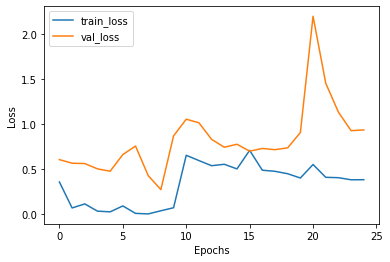

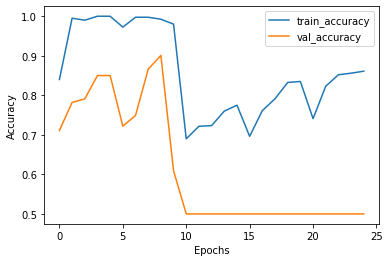

----------------------------------------------------------------------------------------------------
Test set evaluation:  {'loss': 0.18180787563323975, 'binary_accuracy': 0.9635000228881836, 'false_negatives_1': 31.0, 'false_positives_1': 42.0}
----------------------------------------------------------------------------------------------------


In [14]:
active_learning_model = train_active_learning_models(train_dataset, pool_samples, val_dataset, test_dataset)